In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import treecorr as tc
import astroquery
import h5py
from astroquery.sdss import SDSS
from astropy import coordinates as coords
from astropy.coordinates import SkyCoord
from astropy import units as u
import time
from astropy.table import Table
from astropy.coordinates.angle_utilities import angular_separation
from astropy.cosmology import LambdaCDM
import treecorr

In [2]:
def random_sample(ra,dec,size=None):
    """Draw a uniform sample on a sphere covering the same (ra,dec) range
    as the input data.

    Parameters
    ----------
    ra, dec : Right Ascension and Declination in degrees
    size    : Size of the random sample returned

    Returns
    -------
    ra, dec : the random sample on the sphere covering the same region
    Credit: Alex DW (@kadrlica)
    """
    ra = np.atleast_1d(ra)
    dec = np.atleast_1d(dec)
    if size is None: size = len(ra)

    zlim = np.sin(np.pi * np.asarray([dec.min(),dec.max()]) / 180.)

    z = zlim[0] + (zlim[1] - zlim[0]) * np.random.random(size)
    random_dec = (180. / np.pi) * np.arcsin(z)
    random_ra = ra.min() + (ra.max() - ra.min()) * np.random.random(size)
    randoms = np.rec.fromarrays([random_ra,random_dec],names=['ra','dec'])
    return randoms

def weight_func(theta_min, theta_max, gamma=1, nbins=20):
    """
    returns a normalized weight function
    """
    w_init = np.linspace(theta_min, theta_max, nbins)**(-gamma)
    w_init/=np.sum(w_init)
    return w_init

In [3]:
# BOSS = Table.read('/project/chihway/dhayaa/DECADE/BOSS/specObj-BOSS-dr17.fits')
# SDSS = Table.read('/project/chihway/dhayaa/DECADE/BOSS/specObj-SDSS-dr17.fits')
DR17 = Table.read('/project/chihway/dhayaa/DECADE/BOSS/specObj-dr17.fits')

### SDSS DR17 Coverage

In [4]:
galmask = DR17['CLASS']=='GALAXY'

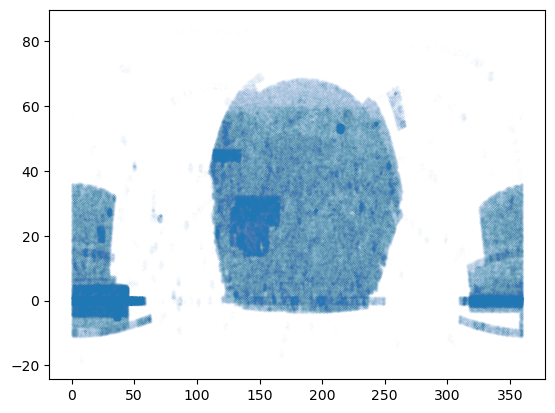

In [ ]:
plt.scatter(DR17['PLUG_RA'][galmask][::3], DR17['PLUG_DEC'][galmask][::3], s=.00005);

(10, 1000000.0)

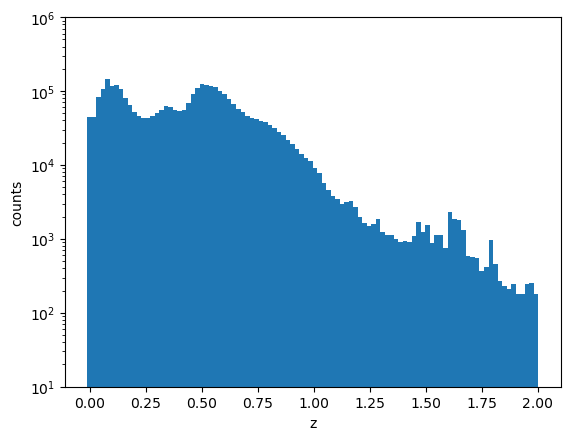

In [6]:
plt.hist(DR17['Z'][galmask], bins=100);
plt.xlabel('z')
plt.ylabel('counts')
plt.yscale('log')
plt.ylim(10, 1e6)

In [2]:
mask = np.load('/project/chihway/raulteixeira/data/metacal_gold_mask.npy')

with h5py.File('/project/chihway/data/decade/metacal_gold_combined_20230613.hdf') as f:
    df = pd.DataFrame()
    df['COADD_OBJECT_ID'] = np.array(f['COADD_OBJECT_ID'])[mask]
    df['RA']=np.array(f['RA'])[mask]
    df['DEC']=np.array(f['DEC'])[mask]

In [15]:
np.array([df['COADD_OBJECT_ID'].values, df['RA'].values, df['DEC'].values]).T

array([[ 7.10930488e+09,  1.52948341e+02, -8.91461800e+00],
       [ 7.10930489e+09,  1.53333488e+02, -8.92277900e+00],
       [ 7.10930490e+09,  1.53088735e+02, -8.91667500e+00],
       ...,
       [ 7.23853376e+09,  1.78801951e+02, -3.19548600e+00],
       [ 7.23853378e+09,  1.78779943e+02, -3.19579900e+00],
       [ 7.23853378e+09,  1.78643687e+02, -3.19576600e+00]])

In [7]:
np.savez('/home/raulteixeira/scratch-midway2/DR3_1_1_ra_dec_id.npz', df_arr)

In [3]:
df_arr = np.rec.array([(df['COADD_OBJECT_ID'].values), (df['RA'].values), (df['DEC'].values)], dtype=[('COADD_OBJECT_ID', 'i8'), ('RA', 'f16'), ('DEC', 'f16')])

In [24]:
df_arr['DEC']==df_arr['RA']

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [5]:
df.to_csv('/home/raulteixeira/scratch-midway2/DR3_1_1_ra_dec_id.csv.gz')

KeyboardInterrupt: 

In [ ]:
df.to_csv('/home/raulteixeira/scratch-midway2//DR3_1_1_ra_dec_id.csv.gz')

In [8]:
# DR17_cd = SkyCoord(ra=DR17['PLUG_RA'][galmask]*u.degree, dec=DR17['PLUG_DEC'][galmask]*u.degree)
# DELVE_cd = SkyCoord(ra=df['RA'].values*u.deg, dec=df['DEC'].values*u.deg)
# idx, d2d, d3d = DELVE_cd.match_to_catalog_sky(DR17_cd)
# good_matches = d2d < 1.0*u.arcsec

# print(len(np.unique(idx[good_matches])), np.count_nonzero(good_matches))

# idx_DR17, d2d_DR17, d3d_DR17 = DR17_cd.match_to_catalog_sky(DELVE_cd)

# good_matches_DR17 = d2d_DR17 < 1.0*u.arcsec

# DR17_cut1 = DR17[galmask][good_matches_DR17]

In [9]:
# plt.scatter(DR17_cut1['PLUG_RA'], DR17_cut1['PLUG_DEC'], s=.02)
# plt.xlabel('RA')
# plt.ylabel('DEC')
# plt.show()

NameError: name 'DR17_cut1' is not defined

In [ ]:
# plt.hist(DR17_cut1['Z'], bins=np.arange(0, 2.02, 0.02))
# plt.xlabel('spec z (SDSS DR17)')
# plt.ylabel('counts')
# plt.yscale('log')
# plt.ylim(1, 2e4)
# plt.show()

In [10]:
ref_delve = pd.read_csv('/project/chihway/raulteixeira/data/WZ/ref_sample/DELVE_DR3_1_1_SDSS_DR17_radecmatch_11112023.csv.gz')
# ref_sdss = DR17[galmask][good_matches_DR17][['PLUG_RA', 'PLUG_DEC', 'Z']]
# ref_delve = df.iloc[idx_DR17[good_matches_DR17]]
# ref_delve['Z']=ref_sdss['Z']
#ref_delve.to_csv('/project/chihway/raulteixeira/data/WZ/ref_sample/DELVE_DR3_1_1_SDSS_DR17_radecmatch_11112023.csv.gz')

#### Redshift Bin Masks

In [11]:
z_r = ref_delve['Z'] # redshifts of reference sample
z_bins = np.arange(0.02, 2.02, 0.02) # bin edges of z_bins

# building a dictionary with a mask for each redshift bin
def z_bin_masks(z, z_bins):
    return {'%.2f'%z_bins[i]+'-%.2f'%z_bins[i+1]:\
            (z_bins[i]<z)&(z<z_bins[i+1]) for i in range(len(z_bins)-1)}

#z_bin_masks_all = z_bin_masks(data['Z'], z_bins)
z_bin_masks_r = z_bin_masks(z_r, z_bins)

print(len(z_bin_masks_r))

print('z bins:', z_bins)

99
z bins: [0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26 0.28
 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54 0.56
 0.58 0.6  0.62 0.64 0.66 0.68 0.7  0.72 0.74 0.76 0.78 0.8  0.82 0.84
 0.86 0.88 0.9  0.92 0.94 0.96 0.98 1.   1.02 1.04 1.06 1.08 1.1  1.12
 1.14 1.16 1.18 1.2  1.22 1.24 1.26 1.28 1.3  1.32 1.34 1.36 1.38 1.4
 1.42 1.44 1.46 1.48 1.5  1.52 1.54 1.56 1.58 1.6  1.62 1.64 1.66 1.68
 1.7  1.72 1.74 1.76 1.78 1.8  1.82 1.84 1.86 1.88 1.9  1.92 1.94 1.96
 1.98 2.  ]


#### Getting Random Sample

In [12]:
config = { 'ra_col' : 'ALPHA2000',
               'dec_col' : 'DELTA2000',
               'g1_col' : 'E1',
               'g2_col' : 'E2',
               'ra_units' : 'deg',
               'dec_units' : 'deg' }

Njk = 20 # number of jackknife regions

n_ref = len(ref_delve)
n_targ = len(df)

rand_ref_coords = random_sample(ref_delve.RA, ref_delve.DEC, size=n_ref)
ref_rand_ra, ref_rand_dec = rand_ref_coords['ra'], rand_ref_coords['dec']

rand_targ_coords = random_sample(df.RA, df.DEC, size=n_targ)
targ_rand_ra, targ_rand_dec = rand_targ_coords['ra'], rand_targ_coords['dec']

In [ ]:
%%time
grid = []
errs = []
weight_grid = []
Cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7) # cosmology used to make rough angular diameter distance measurements

for i, key_r in enumerate(z_bin_masks_r):
    arcsec_p_kpc = Cosmo.arcsec_per_kpc_proper(z=z_bins[i+1])
    min_sep = arcsec_p_kpc*300/60*u.kpc/u.arcsec #in arcmin
    max_sep = min_sep*10 #in arcmin
    print(i, min_sep, max_sep)
    
    #catalogs
    ran_ALL = treecorr.Catalog(ra=df.RA, dec=df.DEC, ra_units='deg', dec_units='deg', npatch=Njk)
    
    cat_targ_rand = treecorr.Catalog(ra=targ_rand_ra, dec=targ_rand_dec, ra_units='deg', dec_units='deg', patch_centers=ran_ALL.patch_centers)
    cat_ref_rand = treecorr.Catalog(ra=ref_rand_ra, dec=ref_rand_dec, ra_units='deg', dec_units='deg', patch_centers=ran_ALL.patch_centers)

    cat_ref = treecorr.Catalog(ra=ref_delve.RA[z_bin_masks_r[key_r]], dec=ref_delve.DEC[z_bin_masks_r[key_r]],\
                               ra_units='deg', dec_units='deg', patch_centers=ran_ALL.patch_centers)
    
    cat_targ = treecorr.Catalog(ra=df.RA, dec=df.DEC,\
                                ra_units='deg', dec_units='deg', patch_centers=ran_ALL.patch_centers)
    
    dd = treecorr.NNCorrelation(config, nbins=20, min_sep=min_sep, max_sep=max_sep,\
                                sep_units='arcmin', var_method='jackknife', bin_slop=0.01)
    rr = treecorr.NNCorrelation(config, nbins=20, min_sep=min_sep, max_sep=max_sep,\
                                sep_units='arcmin', var_method='jackknife', bin_slop=0.01)
    dr = treecorr.NNCorrelation(config, nbins=20, min_sep=min_sep, max_sep=max_sep,\
                                sep_units='arcmin', var_method='jackknife', bin_slop=0.01)
    rd = treecorr.NNCorrelation(config, nbins=20, min_sep=min_sep, max_sep=max_sep,\
                                sep_units='arcmin', var_method='jackknife', bin_slop=0.01) 

    dd.process(cat_targ, cat_ref)
    rr.process(cat_targ_rand, cat_ref_rand)
    dr.process(cat_targ, cat_ref_rand)
    rd.process(cat_targ_rand, cat_ref)
    
    # 2-pt correlation function
    xi, varxi = dd.calculateXi(rr=rr,dr=dr,rd=rd)  # Or get correlation function directly.
    weights = weight_func(min_sep, max_sep, gamma=1, nbins=20)
    var_wbar = np.einsum("i,ij,j->", np.array(weights), dd.cov, np.array(weights))
    weight_grid.append(weights)
    errs.append(np.sqrt(var_wbar))
    grid.append(xi)
    
    # plots
    plt.figure()
    plt.yscale('log')
    plt.ylabel('w(theta)')
    plt.xlabel('theta')
    plt.title(f'z in ({key_r})')
    plt.errorbar(np.linspace(min_sep, max_sep, 20), xi, np.sqrt(varxi))
    plt.show()

0 6.3183654544261305 63.1836545442613
The following patch numbers have no objects: {0, 1, 3, 4, 5}
This may be a problem depending on your use case.
